# CARE Prediction
Please run the `1_CARETraining.ipynb` notebook before going through this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread

from ppn2v.unet.model import UNet
from ppn2v import utils, prediction

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='../../../data/Mouse actin/'

# Load the test data
dataTest=imread(path+"sample_attempt2.tif")[:,:,:512] 
# We are loading only a sub image to speed up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]

### Load the Network and Noise Model
Ensure that ```dataName``` is set same as in ```1_CareTraining.ipynb```.

In [3]:
dataName = 'mouseactin' # Use the same name as used in 1_CareTraining.ipynb. This is a part of model name created in 1_CareTraining.ipynb 
nameModel=dataName+'_care'

In [4]:
# Load the network, created in the '1_CareTraining.ipynb' notebook
net=torch.load(path+"/last_"+nameModel+".net")

### Evaluation

image: 0
PSNR input 23.643400849264026
PSNR CARE 34.087460409482205
-----------------------------------
image: 1
PSNR input 23.620883803207068
PSNR CARE 33.9548052213001
-----------------------------------
image: 2
PSNR input 23.667113469021835
PSNR CARE 33.980953539552765
-----------------------------------
image: 3
PSNR input 23.64709110714436
PSNR CARE 34.120392770455965
-----------------------------------
image: 4
PSNR input 23.672914919463746
PSNR CARE 34.108473959251405
-----------------------------------
image: 5
PSNR input 23.669950605295924
PSNR CARE 34.088033752474864
-----------------------------------
image: 6
PSNR input 23.70231487515842
PSNR CARE 34.012806081049305
-----------------------------------
image: 7
PSNR input 23.705049534851174
PSNR CARE 34.107928100781855
-----------------------------------
image: 8
PSNR input 23.691804110346286
PSNR CARE 34.09181584950004
-----------------------------------
image: 9
PSNR input 23.689684920529743
PSNR CARE 34.15840182562492
--

image: 81
PSNR input 23.725385871950277
PSNR CARE 34.1058268502072
-----------------------------------
image: 82
PSNR input 23.737279746414615
PSNR CARE 34.13778255974988
-----------------------------------
image: 83
PSNR input 23.72013051967217
PSNR CARE 34.062062463973895
-----------------------------------
image: 84
PSNR input 23.707761676550323
PSNR CARE 34.11021839668949
-----------------------------------
image: 85
PSNR input 23.723229436562228
PSNR CARE 34.1759694274054
-----------------------------------
image: 86
PSNR input 23.75004518659601
PSNR CARE 34.08450828656325
-----------------------------------
image: 87
PSNR input 23.725193964406643
PSNR CARE 34.111916894601265
-----------------------------------
image: 88
PSNR input 23.72378242705338
PSNR CARE 34.07862949186223
-----------------------------------
image: 89
PSNR input 23.717076035431152
PSNR CARE 34.13318685220734
-----------------------------------
image: 90
PSNR input 23.72190624789338
PSNR CARE 34.146417774186204

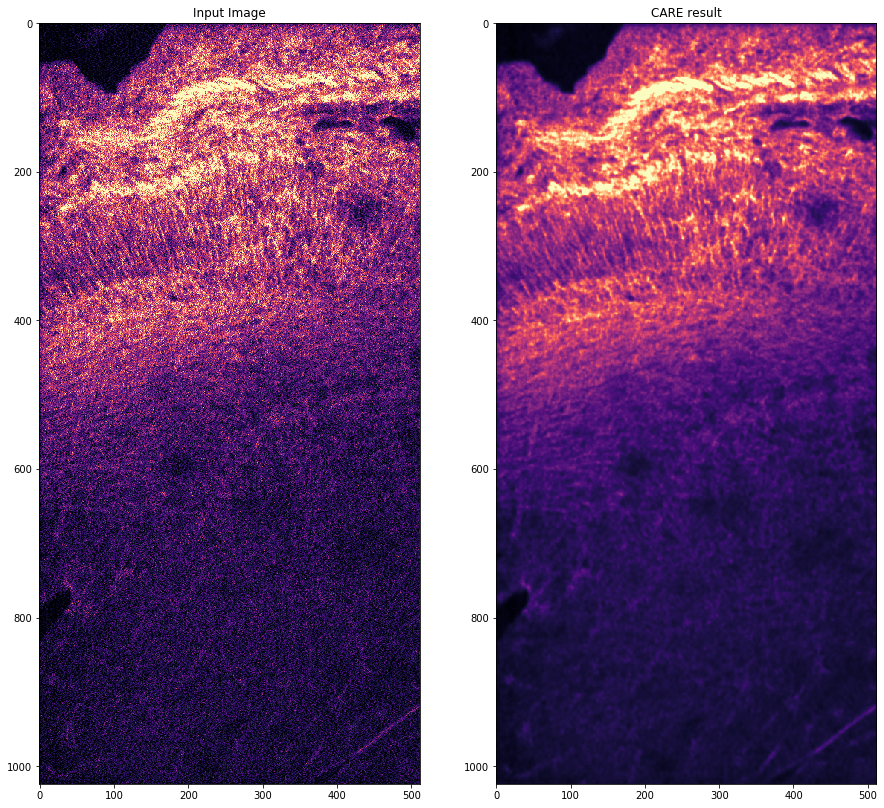

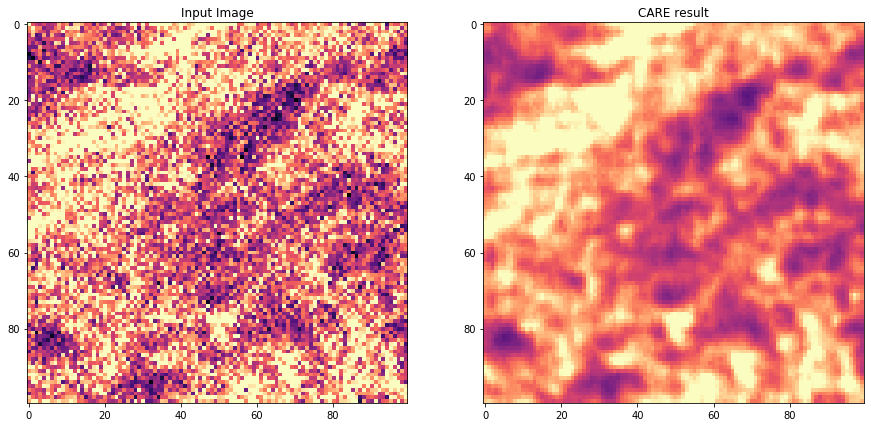

Avg PSNR CARE: 34.100905364692025 +-(2SEM) 0.008880467775026496


In [5]:
# Now we are processing data and calculating PSNR values.
careRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    careResult = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    carePrior=utils.PSNR(gt, careResult,rangePSNR )
    careRes.append(carePrior)

    print ("image:",index)
    print ("PSNR input", utils.PSNR(gt, im, rangePSNR))
    print ("PSNR CARE", carePrior) # Without info from masked pixel
    print ('-----------------------------------')
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/RawImage.png', im)

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult, vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/CARE.png', careResult)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/RawImageSmall.png', im[100:200,150:250])

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/CAREsmall.png', careResult[100:200,150:250])
plt.show()

print("Avg PSNR CARE:", np.mean(np.array(careRes) ), '+-(2SEM)',2*np.std(np.array(careRes) )/np.sqrt(float(len(careRes)) ) )